# Characterizing the metastable states of Alanine Dipeptide
### Approach based on the hierarchical structure of the tICA components.
In this notebook we will use the DeepTICA collective variables of Alanine Dipeptide to characterize its metastable states. We shall make use of the hierarchical structure of the free energy landscape and organize the results as a tree of states of decreasing stability in which states with longer time life are analyzed in terms of their shorter lived components.

In [1]:
#Standard imports
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from itertools import cycle
#MD-related imports
from stateinterpreter import load_trajectory, prepare_training_dataset,Classifier
from stateinterpreter.utils.io import load_dataframe
from stateinterpreter.utils.hierarchical import state_tree,hierarchy_pos,generate_state_labels_from_tree
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,paletteFessa,plot_fes
from stateinterpreter.utils.metrics import get_best_reg
from stateinterpreter.descriptors import compute_descriptors

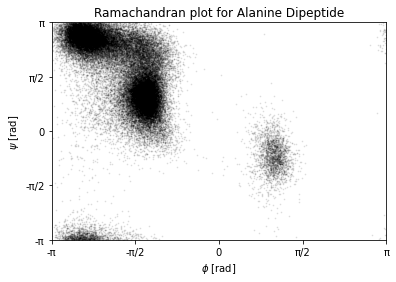

In [2]:
colvar = load_dataframe('alanine/COLVAR_DeepTICA') # Load collective variable file
ax = colvar.plot.scatter('phi','psi',s=0.5, alpha=0.1, c='k')
#Plot Styling
ax.margins(0)
ax.set_xlabel(r"$\phi$ [rad]")
ax.set_ylabel(r"$\psi$ [rad]")
ax.set_title("Ramachandran plot for Alanine Dipeptide")
ax.set_xticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_xticklabels(['-π','-π/2','0','π/2','π'])
ax.set_yticks(np.arange(-np.pi, np.pi+np.pi/2, step=(np.pi/2)))
ax.set_yticklabels(['-π','-π/2','0','π/2','π'])
plt.show()

### Descriptors
We now show how to use the helper functions implemented in `stateinterpreter` to calculate the physical descriptors starting from a molecular dynamics trajectory. In the present case we compute the H-bonds contacts and the dihedral angles.

In [3]:
traj_dict = {
    'trajectory' : 'alanine/alanine.xtc',
    'topology' : 'alanine/input.ala2.pdb'
}

traj = load_trajectory(traj_dict)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['hbonds_contacts','dihedrals'] )
descriptors.head()

Computing Hydrogen bonds contacts
Donors: [6, 16]
Acceptors: [ 5  6 15 16]
Descriptors: (50001, 10)


,HB_C ACE1-O -- ALA2-N,HB_C ACE1-O -- NME3-N,HB_C ALA2-N -- NME3-N,HB_C ALA2-O -- NME3-N,phi ACE1,sin_phi ACE1,cos_phi ACE1,psi ALA2,sin_psi ALA2,cos_psi ALA2
0,0.929044,0.100502,0.459074,0.930207,-2.368267,-0.698519,-0.715592,2.643943,0.477362,-0.878707
1,0.933527,0.260737,0.487284,0.934357,-1.818813,-0.969401,-0.245482,2.266428,0.767649,-0.640871
2,0.938087,0.183339,0.458683,0.942874,-1.962519,-0.924253,-0.381781,2.518990,0.583152,-0.812363
3,0.923064,0.237140,0.409412,0.943660,-1.546074,-0.999694,0.024719,2.609307,0.507504,-0.861649
4,0.941426,0.719332,0.687630,0.937150,-1.434391,-0.990711,0.135983,1.046329,0.865591,0.500752


### Hierarchical classification
We now use the utilities implemented in `stateinterpreter.utils.hierarchical` to automatically build a tree of metastable states of decreasing stability starting only from the DeepTICA values.

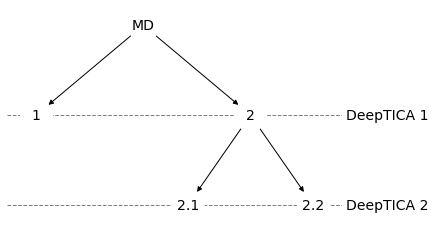

In [4]:
cvs = colvar[['DeepTICA 1','DeepTICA 2']].values # Extract the DeepTICA CV values
bandwidth = 0.05 # Set the bandwidth for the Gaussian kernel used in the KDE approximation

#Bias correction
kbt = 2.5
logweights = colvar['opes.bias'].values/kbt

# Build tree of metastable states
T = state_tree(cvs, bandwidth, logweights=logweights)

# Draw tree
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 14,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}
fig, ax = plt.subplots()
ax.axhline(y = pos['1'][1], color = 'gray', linewidth = 1, linestyle = '--')
ax.axhline(y = pos['2.1'][1], color = 'gray', linewidth = 1, linestyle = '--')
ax.text(pos['2.2'][0] + 0.1, pos['2'][1], 'DeepTICA 1', fontsize = 14, backgroundcolor = 'white', va = 'center')
ax.text(pos['2.2'][0] + 0.1, pos['2.2'][1], 'DeepTICA 2', fontsize = 14, backgroundcolor = 'white', va = 'center')
nx.draw(T, pos, ax, **options)

In [5]:
# Generate the labels for state classification (one dataframe for each branch)
labels_list = generate_state_labels_from_tree(T, root='MD', fes_threshold=1 ) 

# Get tICA components names corresponding to each branch
cv_list = []
for states_labels in labels_list:
    states_subset = states_labels['labels'].unique()
    states_subset = states_subset[states_subset != 'undefined' ]

    cv_level = states_subset[0].count('.')+1
    cv_list.append( [f'DeepTICA {cv_level}'] )


print(f"Example: first 5 labels for the states corresponding to {cv_list[0][0]}.")
labels_list[0].head()

Example: first 5 labels for the states corresponding to DeepTICA 1.


,labels,selection
0,2,True
1,2,True
2,2,True
3,2,True
4,2,True


### Metastable states characterization based on dihedral angles

In [6]:
feat_type = 'angles' #Select feature type
select_feat = 'sin_|cos_' #Regex to filter angle
desc = descriptors.filter(regex=select_feat)
print('Example of the selected descriptors')
desc.head()

Example of the selected descriptors


,sin_phi ACE1,cos_phi ACE1,sin_psi ALA2,cos_psi ALA2
0,-0.698519,-0.715592,0.477362,-0.878707
1,-0.969401,-0.245482,0.767649,-0.640871
2,-0.924253,-0.381781,0.583152,-0.812363
3,-0.999694,0.024719,0.507504,-0.861649
4,-0.990711,0.135983,0.865591,0.500752


DeepTICA 1


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 753.28it/s]

Best log_10 (lambda) : -0.88
Accuracy        : 100.0 %
No. features    : 1


Accuracy: 100%
State 2:
 sin_phi ACE1


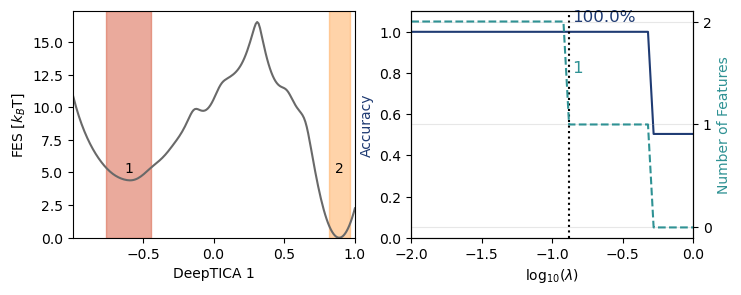

DeepTICA 2


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 830.08it/s]

Best log_10 (lambda) : -0.6
Accuracy        : 99.0 %
No. features    : 1
Accuracy: 99%
State 2.2:
 cos_psi ALA2


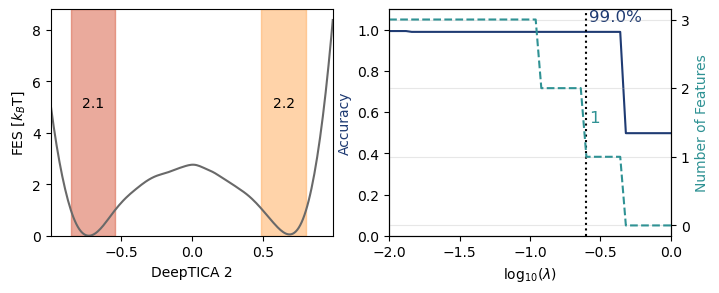

In [7]:
# state labels TODO COmment
for cvs, states_labels in zip(cv_list,labels_list):
    print(cvs[0])

    # Init classifier
    regularizers = np.geomspace(0.01, 1, 51)
    num_samples = 1000 # number of configurations used to train the classifier

    sample_obj, features_names = prepare_training_dataset(
        descriptors=desc, 
        states_labels = states_labels, 
        n_configs= num_samples
    ) 
    classifier = Classifier(sample_obj, features_names)
    classifier.compute(regularizers, max_iter = 10000) # Train the classifier

    # Extract optimal regularization parameter
    reg,acc,num = get_best_reg(classifier)
    print(f'Best log_10 (lambda) : {np.round(np.log10(reg),3)}')
    print(f'Accuracy        : {np.round(acc*100,0)} %')
    print(f'No. features    : {num}')

    # Count states (for plotting purposes)
    num_states = len(classifier.classes)
    num_histo = num_states if num_states>2 else 1

    # Classes names (for plotting purposes)
    relevant_feat = classifier.feature_summary(reg)
    classes_names = classifier.classes

    # Init Plot
    fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),dpi=100)

    # Init Colors 
    colors = cycle(iter(paletteFessa[::-1]))
    color = [next(colors) for i in range(5)]

    # Plot Free Energy Surface
    cv_plot = colvar [states_labels['labels'] != 'undefined']
    logw_plot=None
    if logweights is not None:
        logw_plot = logweights[states_labels['labels'] != 'undefined']
    
    plot_fes(
        cv_plot[cvs],
        bandwidth,
        states_labels,
        logweights=logw_plot,
        num_samples=200,
        ax=ax,
        colors=color
    )

    # Plot regularization paths.
    ax = ax2
    _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
    ax.axvline(np.log10(reg),linestyle='dotted',color='k')
    ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
    ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

    #Print relevant features
    classifier.print_selected(reg)
    plt.show()